# Imports

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

# Dataset

A gente vai usar um dataset padrão do `scipy`, adicionando algumas variáveis "inventadas" para deixar a brincadeira mais divertida.

In [ ]:
boston = datasets.load_boston()

dados = pd.DataFrame(boston['data'], columns = boston['feature_names'])
resposta = pd.DataFrame(boston['target'])

dados.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Adiciona mais variáveis

Criamos uma data falsa

In [ ]:
dados['data'] = np.round((dados['B'].rank() + np.random.randint(0, 506, 506)) / 15, 0)
data_backup = dados['data']

Aplicamos algumas transformações aleatórias para criar variáveis adicionais.

In [ ]:
def transforma_coluna(s1):
    func = np.random.choice([np.sqrt, np.log, np.sin, np.cos, np.tan, np.abs])
    values = func(abs(s1) * np.random.uniform() + 0.001)
    values[np.abs(values) == np.inf] = np.nan
    return values

def injeta_nulos(s1):
    rand = np.random.random(len(s1))
    s1_copy = s1
    s1_copy[rand < np.random.random() * 0.18] = np.nan
    return s1_copy

def mistura_colunas(s1, s2):
    r = np.random.randint(0, 4)
    if r == 0:
        return injeta_nulos(s1) + injeta_nulos(s2)
    if r == 1:
        return injeta_nulos(s1) * injeta_nulos(s2)
    if r == 2:
        return injeta_nulos(s1) / injeta_nulos(s2)
    if r == 3:
        return np.round(injeta_nulos(s1), 0)

for n in range(200):
    c1 = np.random.choice(dados.columns)
    c2 = np.random.choice(dados.columns)
    c1 = np.random.uniform() * transforma_coluna(dados[c1])
    c2 = np.random.uniform() * transforma_coluna(dados[c2])
    dados[str(np.random.uniform())] = mistura_colunas(c1, c2)

In [ ]:
dados.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,data,0.4151743661028323,0.7181355418874744,0.19949825675952026,0.36424088929862575,0.007764560826332478,0.17815356712473474,0.8747101735456664,0.02877520064035821,0.41871780511828205,0.671354965942584,0.6524544470864062,0.3692888542318181,0.9993010906786328,0.454117576879734,0.7030057800572062,0.14332022826429713,0.9708606477181564,0.19128929320837684,0.47546503022448816,0.30935173153502804,0.39494138454486727,0.09397041042392307,0.3424601718866491,0.9610535190198317,0.2582928051533273,0.4539127777717147,...,0.6244862515475372,0.4624667814445149,0.2183281813085135,0.05243211007240456,0.8472933575628481,0.016602792981845416,0.927203906141,0.5497286298759844,0.9663914552298609,0.05567779156563646,0.8454258796925356,0.07957335533133203,0.15405416322947818,0.21276588505246463,0.07502466451491052,0.6886413484778959,0.9652950506828123,0.1693609029611468,0.9628380231402597,0.3697431098884634,0.9246251170865383,0.749605794414441,0.8091382984269258,0.6098721435964548,0.2714475932864969,0.8159373260251576,0.09505012861309681,0.9658694972003796,0.4201820291356865,0.8702569200856269,0.1209617592909219,0.1313345084365738,0.15696425855099327,0.15161450099680474,0.3870485478047768,0.6964266728427709,0.011880795709647729,0.529025329589781,0.7619558743572893,0.11428941820658556
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,43.0,0.616000,NaN,0.0,-0.003716,-0.000022,0.105681,-0.120791,-0.341749,NaN,-0.066153,-0.0,NaN,-0.016348,1.108735,-0.0,0.033996,NaN,NaN,24.234208,-168.098802,NaN,NaN,NaN,NaN,-0.442427,0.846523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.739895,-22.026470,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-1.161450,4.304434,NaN,NaN,2.0,NaN,NaN,NaN,0.000026,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.127286e-07,NaN,0.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,49.0,NaN,0.604345,-0.0,0.002697,0.000368,0.093257,-0.053052,1.805196,-0.744426,0.221207,-0.0,NaN,NaN,NaN,1.0,0.170663,-0.017723,NaN,NaN,-172.567844,NaN,NaN,NaN,NaN,-0.531401,0.913177,...,NaN,NaN,NaN,NaN,NaN,NaN,0.470725,NaN,3.0,NaN,NaN,NaN,0.147603,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4.304434,NaN,NaN,2.0,NaN,NaN,0.0,0.000080,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,43.0,-0.330477,0.604344,0.0,-0.013515,-0.000022,0.088162,-0.060362,1.744118,-0.744790,0.221207,-0.0,0.0,-0.029816,NaN,1.0,0.165344,-0.017723,-0.000210,NaN,-133.651743,0.009489,0.000538,NaN,0.985779,-0.531401,0.913006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.186467e-07,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,0.0,0.000080,0.012438,0.0,-0.848813,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,38.0,0.585403,0.604650,-0.0,NaN,-0.000131,0.087242,-0.195912,1.686316,NaN,NaN,-0.0,0.0,NaN,NaN,-0.0,0.160270,NaN,-0.000188,NaN,-97.574051,0.008738,0.000538,NaN,NaN,-0.546781,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.487881,NaN,0.0,NaN,1.739895,-14.128106,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-1.140603,4.304434,NaN,NaN,2.0,NaN,NaN,0.0,0.000025,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,62.0,0.603070,0.606856,-0.0,NaN,0.000404,NaN,-0.096927,NaN,NaN,-0.085767,-0.0,0.0,NaN,NaN,-0.0,NaN,NaN,-0.000016,NaN,-100.752385,0.006035,NaN,NaN,NaN,-0.546388,NaN,...,0.0,NaN,NaN,0.605044,NaN,NaN,0.487882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,-0.004332,NaN,NaN,0.000025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


## Treino e Teste

In [ ]:
ids_treino = list(np.random.choice(dados.index, int(500 * 0.7), replace=False))
ids_teste = [id for id in dados.index if id not in ids_treino]

dados_treino = dados.loc[ids_treino, ]
resposta_treino = resposta.loc[ids_treino, ]
dados_teste = dados.loc[ids_teste, ]
resposta_teste = resposta.loc[ids_teste, ]

dados_treino.shape, resposta_treino.shape, dados_teste.shape, resposta_teste.shape

((350, 214), (350, 1), (156, 214), (156, 1))

# Filtering

## Nulos

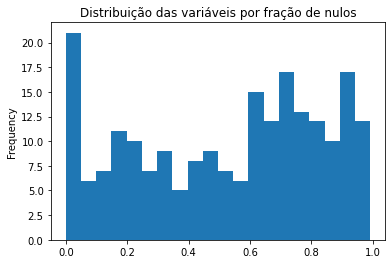

In [ ]:
contagem_de_nulos = dados_treino.isna().mean()

contagem_de_nulos.plot.hist(bins=20)
plt.title("Distribuição das variáveis por fração de nulos")
plt.show()

In [ ]:
remover_nulos = contagem_de_nulos[contagem_de_nulos >= 0.95].index
selecionadas = [var for var in dados_treino.columns if var not in remover_nulos]

len(remover_nulos)

11

In [ ]:
dados_treino = dados_treino[selecionadas]
dados_teste = dados_teste[selecionadas]

## Baixa Variância

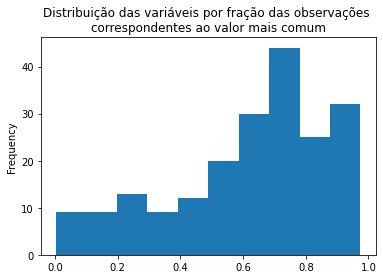

In [ ]:
val_unicos = dados_treino.apply(lambda x: x.value_counts(dropna=False).values[0] / len(dados_treino), axis=0)

val_unicos.plot.hist()
plt.title("Distribuição das variáveis por fração das observações \ncorrespondentes ao valor mais comum")
plt.show()

In [ ]:
remover_cat_dominante = val_unicos[val_unicos >= 0.95].index
selecionadas = [var for var in dados_treino.columns if var not in remover_cat_dominante]

len(remover_cat_dominante)

3

In [ ]:
dados_treino = dados_treino[selecionadas]
dados_teste = dados_teste[selecionadas]

Para olhar para a variância, e não só para valores repetidos, precisamos primeiro colocar os dados na mesma escala.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
dados_mesma_escala = min_max_scaler.fit_transform(dados_treino)
dados_mesma_escala = pd.DataFrame(dados_mesma_escala, columns=dados_treino.columns)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=.01)
dados_mesma_escala = selector.fit_transform(dados_mesma_escala)

remover_variancia = dados_treino.columns[~selector.get_support()]
selecionadas = [var for var in dados_treino.columns if var not in remover_variancia]

len(remover_variancia)

60

In [ ]:
dados_treino = dados_treino[selecionadas]
dados_teste = dados_teste[selecionadas]

## Correlação

In [ ]:
correlacao = dados_treino.corr()

Correlações (ordenadas para ficar mais visível e bonito)

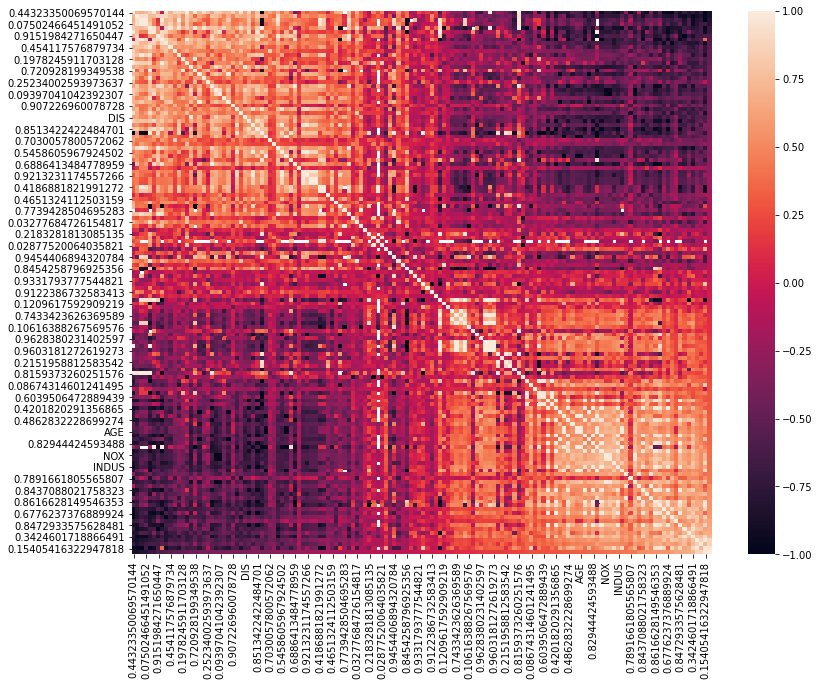

In [ ]:
correlacao = correlacao.sort_values(by=correlacao.columns[0], axis=0).sort_values(by=correlacao.columns[0], axis=1)

plt.figure(figsize=(13, 10))
sns.heatmap(correlacao)
plt.show()

Vamos ordenar as variáveis por cobertura para que as variáveis removidas sejam sempre as de menor cobertura:

In [ ]:
ordem = list(dados_treino.isna().mean().sort_values().index)

correlacao = correlacao.loc[ordem, ordem].abs()

superior = correlacao.where(np.triu(np.ones(correlacao.shape), k=1).astype(np.bool))

remover_correlacao = [column for column in superior.columns if any(superior[column] > 0.95)]
selecionadas = [var for var in dados_treino.columns if var not in remover_correlacao]

len(remover_correlacao)

68

In [ ]:
dados_treino = dados_treino[selecionadas]
dados_teste = dados_teste[selecionadas]

In [ ]:
dados_treino.shape, dados_teste.shape

((350, 72), (156, 72))

# SF embutida

## Lasso

O primeiro passo é fazer imputação de 0s já que esse método não suporta nulos. Para não se complicar nesse tutorial, vamos usar 0 para tudo.

In [ ]:
dados_treino_lasso = dados_treino.copy()
dados_treino_lasso = dados_treino_lasso.fillna(0)

Modelos lineares também se beneficiam de colocar as variáveis na mesma escala. Dessa vez não tem problema de normalizar.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dados_treino_lasso)

dados_treino_lasso_norm = scaler.transform(dados_treino_lasso)

Vamos treinar um modelo de Lasso:

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(dados_treino_lasso_norm, resposta_treino)

pd.DataFrame({"feature": dados_treino_lasso.columns, "coeficiente_lasso": lasso.coef_}).sort_values('coeficiente_lasso', ascending=False).head(20)

,feature,coeficiente_lasso
5,RM,2.115690
1,ZN,0.756704
3,CHAS,0.725924
11,B,0.684118
8,RAD,0.648361
26,0.30935173153502804,0.594807
44,0.2151958812583542,0.584186
20,0.671354965942584,0.532362
14,0.4151743661028323,0.396240
53,0.08674314601241495,0.316045


Podemos também fazer uma validação cruzada bonita aqui para achar o melhor parâmetro `alpha`.

In [ ]:
from sklearn.linear_model import LassoCV

fit = LassoCV(random_state=0).fit(dados_treino_lasso_norm, np.array(resposta_treino).flatten())

In [ ]:
fit.alpha_

0.19004430544956716

In [ ]:
pd.DataFrame({"feature": dados_treino_lasso.columns, "coeficiente_lasso": fit.coef_}).sort_values('coeficiente_lasso', ascending=False).head(20)

,feature,coeficiente_lasso
5,RM,2.274611
3,CHAS,0.671411
11,B,0.570176
44,0.2151958812583542,0.515137
1,ZN,0.493212
26,0.30935173153502804,0.412140
14,0.4151743661028323,0.391632
68,0.3697431098884634,0.190765
53,0.08674314601241495,0.110933
37,0.7409495023021287,0.084881


# Wrappers

## Floresta Aleatória

Um exemplo simples de seleção de variáveis.

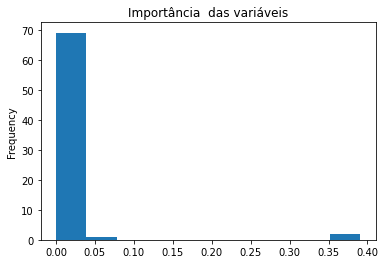

In [ ]:
from sklearn.ensemble import RandomForestRegressor

dados_treino_rf = dados_treino.copy()
dados_treino_rf = dados_treino_rf.fillna(0)

dados_teste_rf = dados_teste.copy()
dados_teste_rf = dados_teste_rf.fillna(0)

model = RandomForestRegressor(n_estimators=100)
model.fit(dados_treino_rf, np.array(resposta_treino).flatten())

importances = model.feature_importances_

pd.Series(importances).plot.hist()
plt.title("Importância  das variáveis")
plt.show()

In [ ]:
from sklearn.metrics import r2_score

treino_r2 = []
teste_r2 = []
variaveis = []

vars_selecionadas = dados_treino.columns

for i in range(len(dados_treino.columns)):
    model = RandomForestRegressor(n_estimators=10)
    model.fit(dados_treino_rf[vars_selecionadas], np.array(resposta_treino).flatten())
    
    importancias = model.feature_importances_
    remover = pd.Series(importancias, index=vars_selecionadas).sort_values().index[0]

    treino_r2.append(r2_score(model.predict(dados_treino_rf[vars_selecionadas]), resposta_treino))
    teste_r2.append(r2_score(model.predict(dados_teste_rf[vars_selecionadas]), resposta_teste))
    variaveis.append(vars_selecionadas)

    vars_selecionadas = [f for f in vars_selecionadas if f != remover]

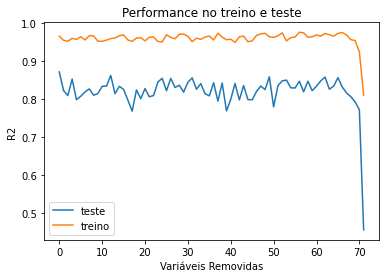

In [ ]:
df=pd.DataFrame({"teste": teste_r2, "treino": treino_r2})#.rolling(5, min_periods=1).mean()
df.plot()
plt.title("Performance no treino e teste")
plt.xlabel("Variáveis Removidas")
plt.ylabel("R2")
plt.show()

In [ ]:
ordem = dados_treino.corr().sum().abs().sort_values(ascending=False).index

In [ ]:
ordem

Index(['0.47546503022448816', '0.02877520064035821', 'data',
       '0.6098721435964548', '0.1978245911703128', '0.11987975142910867', 'B',
       '0.07502466451491052', '0.8747101735456664', '0.8862898133351137',
       '0.342982526624108', '0.11865172426660531', '0.7030057800572062',
       'CRIM', '0.7891661805565807', '0.05830004505540565',
       '0.4651324112503159', '0.4521631214908455', '0.36424088929862575',
       '0.1209617592909219', '0.9628380231402597', '0.9122386732583413',
       '0.3350335971687758', 'AGE', '0.9993010906786328', '0.1979674818482723',
       '0.14147639047620375', '0.8912199120598356', '0.25234002593973637',
       '0.907226960078728', '0.671354965942584', '0.9331793777544821',
       '0.8091382984269258', '0.927203906141', '0.2966874134173202',
       '0.19128929320837684', '0.016602792981845416', '0.3697431098884634',
       '0.3480292696434606', '0.3424601718866491', 'RM', 'PTRATIO',
       '0.7181355418874744', '0.30935173153502804', '0.487712398549

In [ ]:
from sklearn.metrics import r2_score

treino_r2 = []
teste_r2 = []
variaveis = []

vars_selecionadas = dados_treino.columns

for i in range(len(dados_treino.columns)):
    model = RandomForestRegressor(n_estimators=10)
    model.fit(dados_treino_rf[vars_selecionadas], np.array(resposta_treino).flatten())
    
    # importancias = model.feature_importances_
    remover = ordem[i]

    treino_r2.append(r2_score(model.predict(dados_treino_rf[vars_selecionadas]), resposta_treino))
    teste_r2.append(r2_score(model.predict(dados_teste_rf[vars_selecionadas]), resposta_teste))
    variaveis.append(vars_selecionadas)

    vars_selecionadas = [f for f in vars_selecionadas if f != remover]

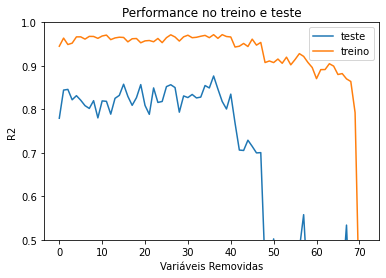

In [ ]:
df=pd.DataFrame({"teste": teste_r2, "treino": treino_r2})#.rolling(5, min_periods=1).mean()
df.plot()
plt.title("Performance no treino e teste")
plt.xlabel("Variáveis Removidas")
plt.ylabel("R2")
plt.ylim([0.5, 1.0])
plt.show()

In [ ]:
vars_selecionadas

## Importâncias Shap

In [ ]:
!pip install shap

In [ ]:
import shap
from xgboost import XGBRegressor

In [ ]:
model = XGBRegressor(objective='reg:squarederror')
model.fit(dados_treino, np.array(resposta_treino).flatten())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

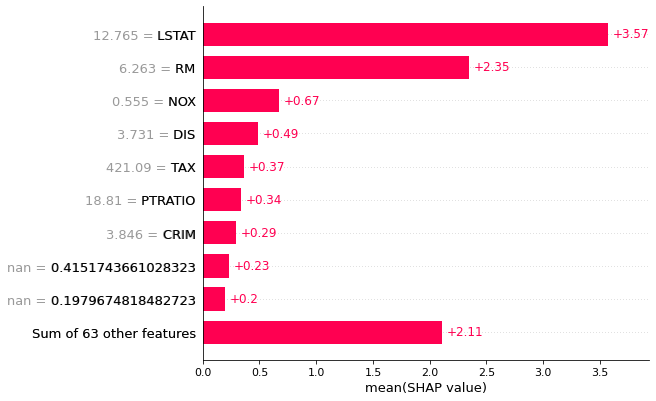

In [ ]:
exp = shap.TreeExplainer(model)
shap_vals = exp(dados_teste)
expected_value = exp.expected_value

shap.plots.bar(shap_vals)

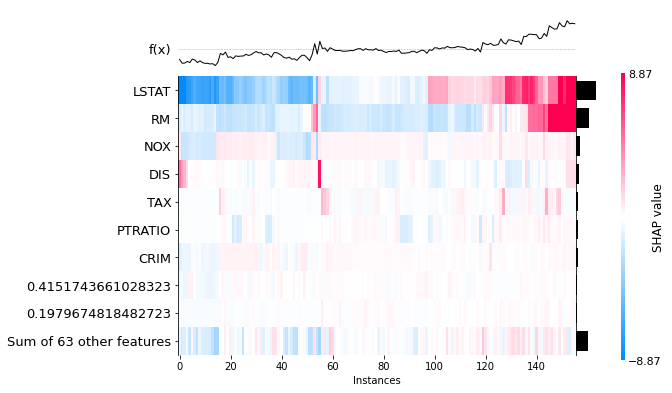

In [ ]:
shap.plots.heatmap(shap_vals)

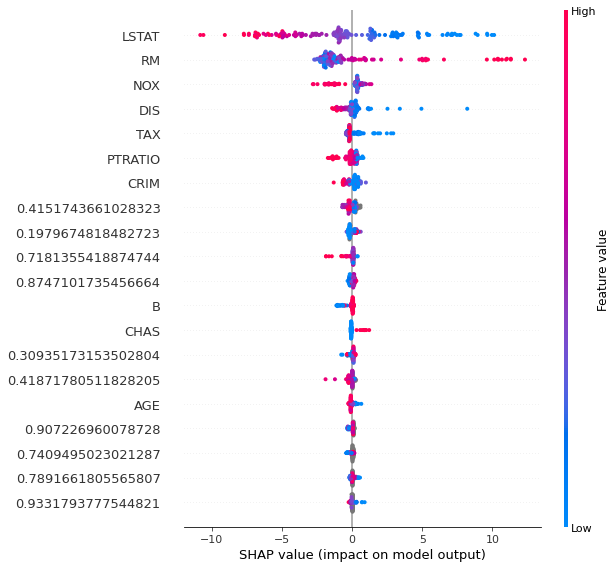

In [ ]:
shap.summary_plot(shap_vals.values, dados_teste)

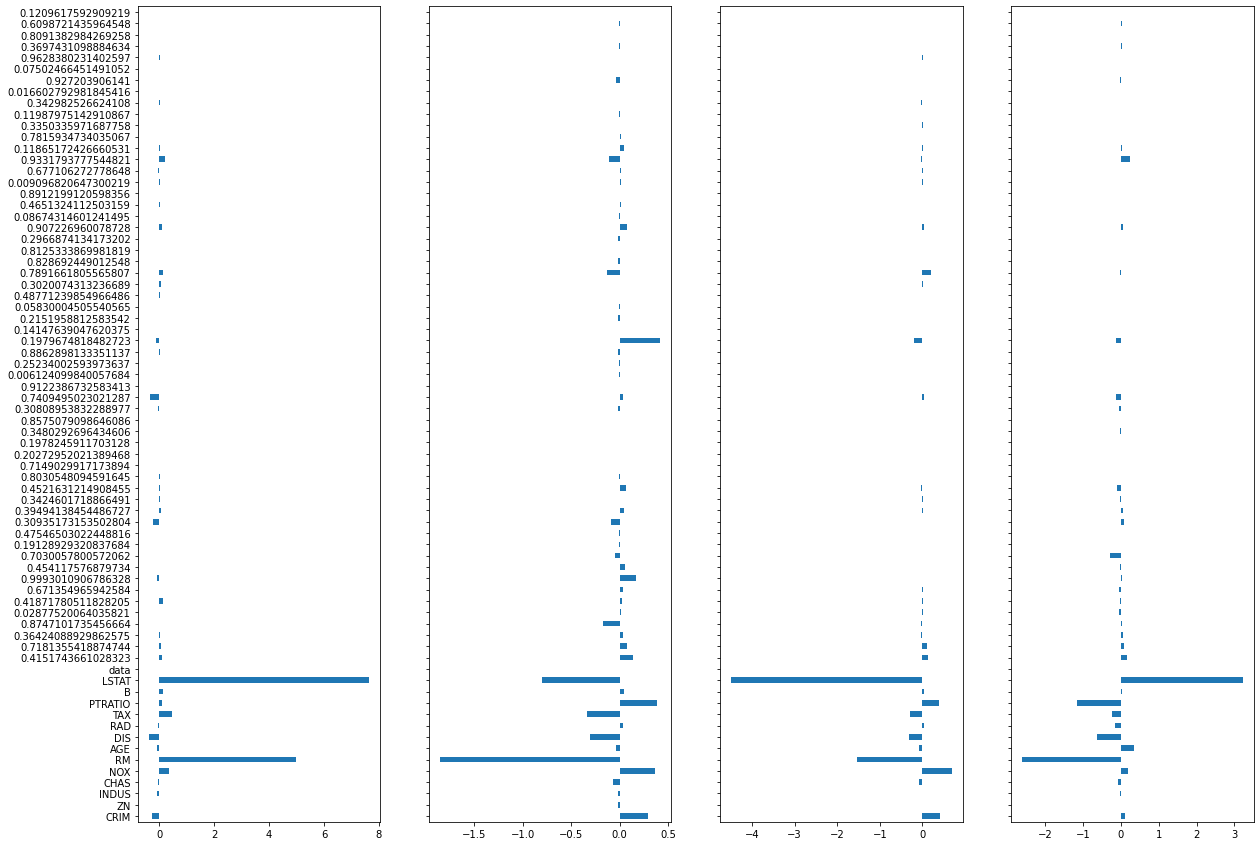

In [ ]:
shap_df = pd.DataFrame(shap_vals.values, columns=dados_teste.columns)
fig, ax = plt.subplots(1, 4, figsize=(20,15), sharey=True)

shap_df.iloc[0].plot.barh(ax=ax[0])
shap_df.iloc[1].plot.barh(ax=ax[1])
shap_df.iloc[2].plot.barh(ax=ax[2])
shap_df.iloc[3].plot.barh(ax=ax[3])

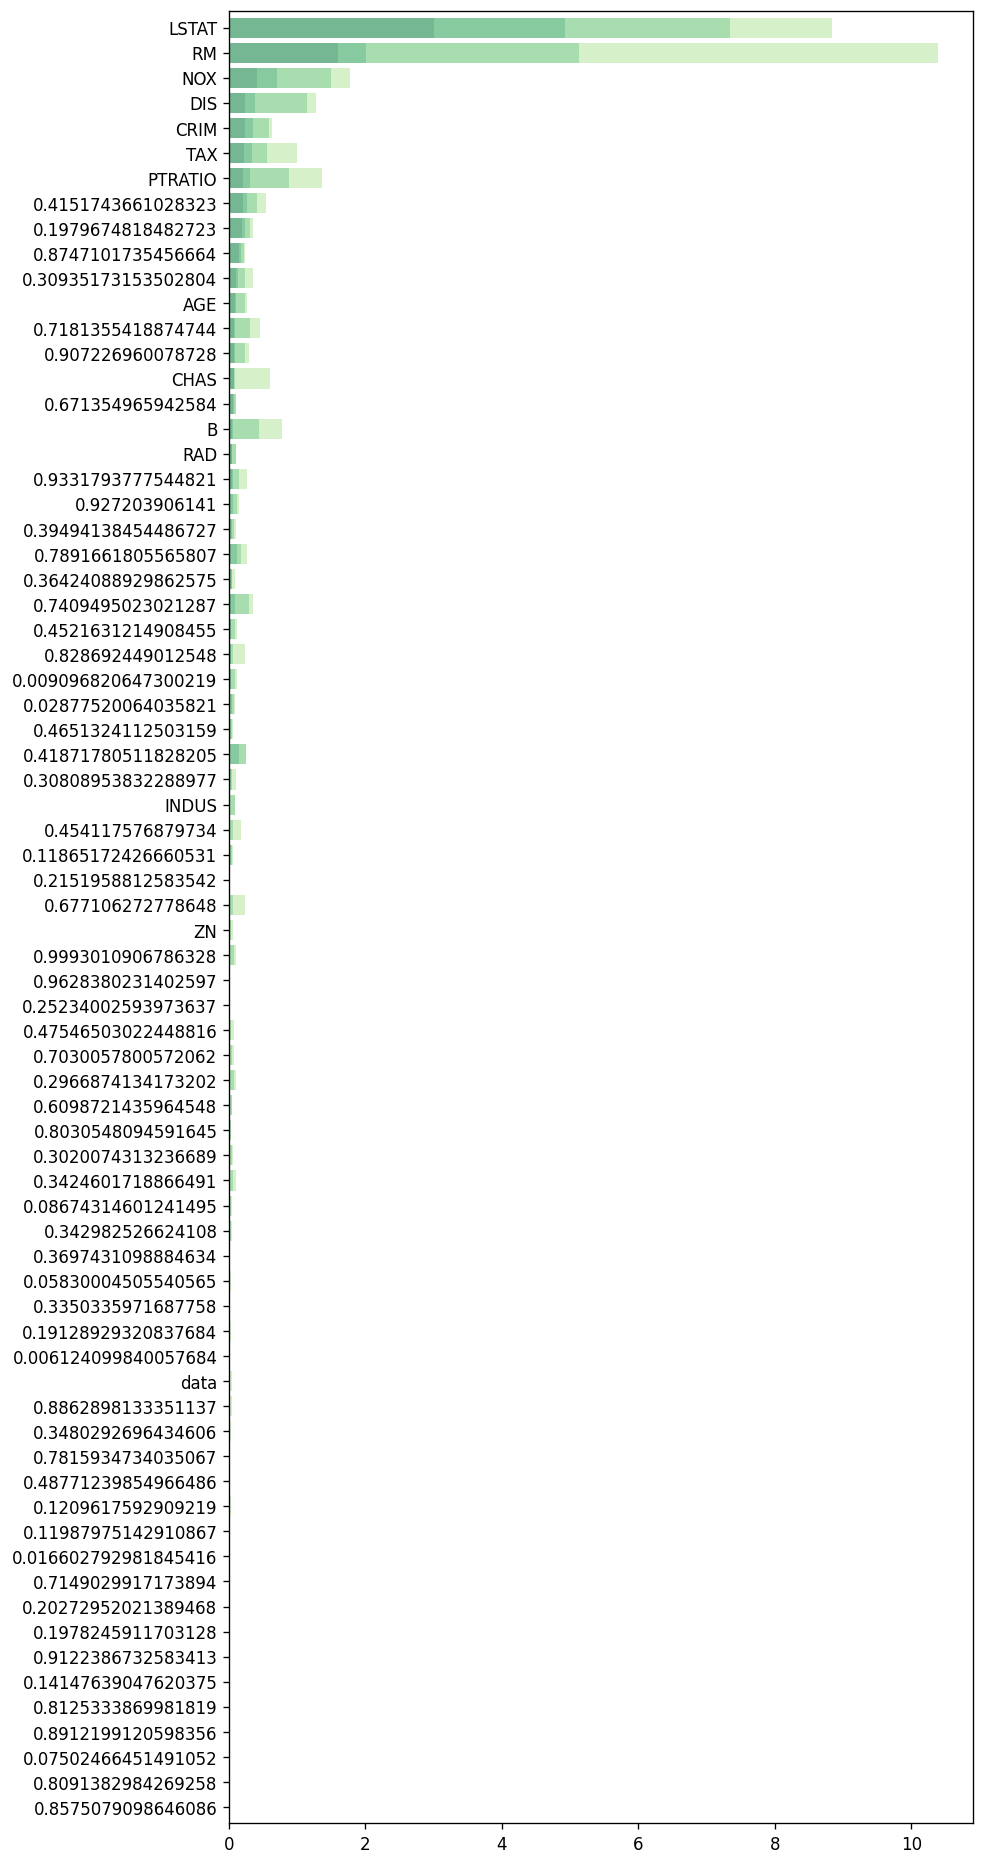

In [ ]:
quantiles_df = shap_df.abs().quantile([.5, .7, .9, .95]).T.sort_values(.5, ascending=True)
colors = sns.color_palette('viridis', 4)

plt.figure(figsize=(8,20), dpi=120)
for i, q in enumerate(quantiles_df.columns):
  quantiles_df[q].plot.barh(color=colors[i], alpha=0.3, width=.8)

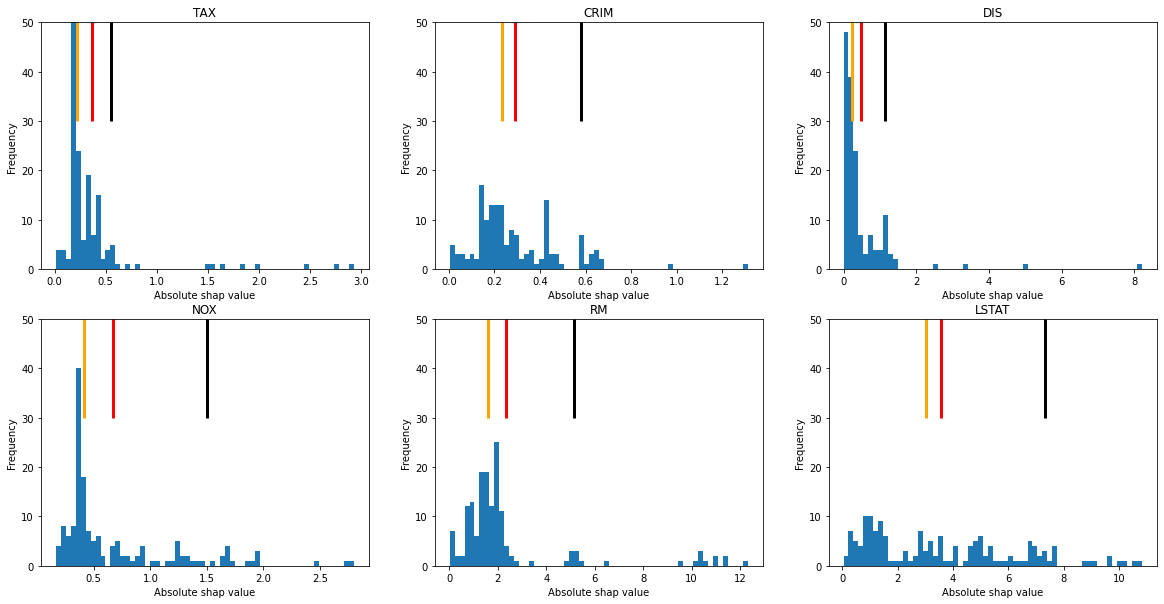

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
for i, feat in enumerate(quantiles_df.index[-6:]):
  hist = shap_df[feat].abs().plot.hist(bins=60, ax=ax[int(i / 3), i % 3]);            
  ax[int(i / 3), i % 3].set_title(feat)
  ax[int(i / 3), i % 3].vlines([shap_df[feat].abs().mean(), shap_df[feat].abs().median(), shap_df[feat].abs().quantile(.9)], 30, 50, colors=['r','orange','k'], linewidth=3)
  ax[int(i / 3), i % 3].set_ylim(0,50)
  ax[int(i / 3), i % 3].set_xlabel("Absolute shap value")

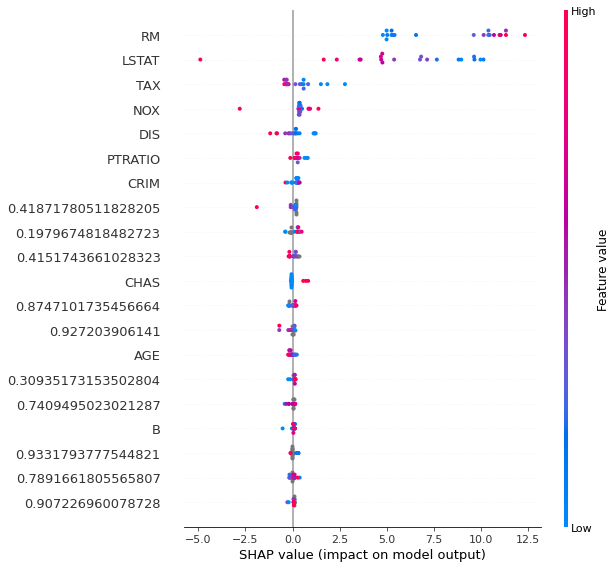

In [ ]:
# shap_df

shap.summary_plot(shap_vals.values[shap_df['RM'] > 4], dados_teste[(shap_df['RM'] > 4).values])

In [ ]:
from itertools import chain, combinations
from collections import Counter
selecoes = []
for i in range(50):
    indexes_200 = np.random.permutation(350)[:200]
    selecionadas = reduzir_ate_20(dados_treino_rf.iloc[indexes_200], resposta_treino.iloc[indexes_200])
    selecoes.append(selecionadas)
def IOU(conj1, conj2):
  return len(set(conj1).intersection(conj2)) / len(set(conj1).union(conj2))
plt.hist([IOU(c1, c2) for c1, c2 in combinations(selecoes, 2)]);

NameError: ignored